# Alignment algorithm

This notebook explains the details on the Viterbi alignment procedure using the Huggingface Transformers library. The goal of the algorithm is to match a word sequence to recorded speech.

In [1]:
from typing import Tuple, List

import numpy as np
import torchaudio
from IPython.display import Audio as IPyAudio
from matplotlib.patches import Rectangle
from matplotlib.pyplot import (
    figure,
    plot,
    pcolormesh,
    yticks,
    scatter,
    subplots,
    xlabel,
)
from transformers import Wav2Vec2Processor, AutoModelForCTC
from datasets import Dataset, Audio

We start by loading a speech model.

In [2]:
w2v2_model = "classla/wav2vec2-large-slavic-parlaspeech-hr"
processor = Wav2Vec2Processor.from_pretrained(str(w2v2_model))
model = AutoModelForCTC.from_pretrained(str(w2v2_model)).cuda()

/home/peterr/mambaforge/envs/transformers/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at classla/wav2vec2-large-slavic-parlaspeech-hr were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be

We will use a specific short piece of audio from a pre-determined location in our file.

In [3]:
audio = Dataset.from_dict({"audio": ["data/MPmp3/MP_13_65.37-74.67.mp3"]}).cast_column(
    "audio", Audio(sampling_rate=16000, mono=True)
)[0]["audio"]["array"]
IPyAudio(audio, rate=16000)

This is what the audio looks like in graphical form.

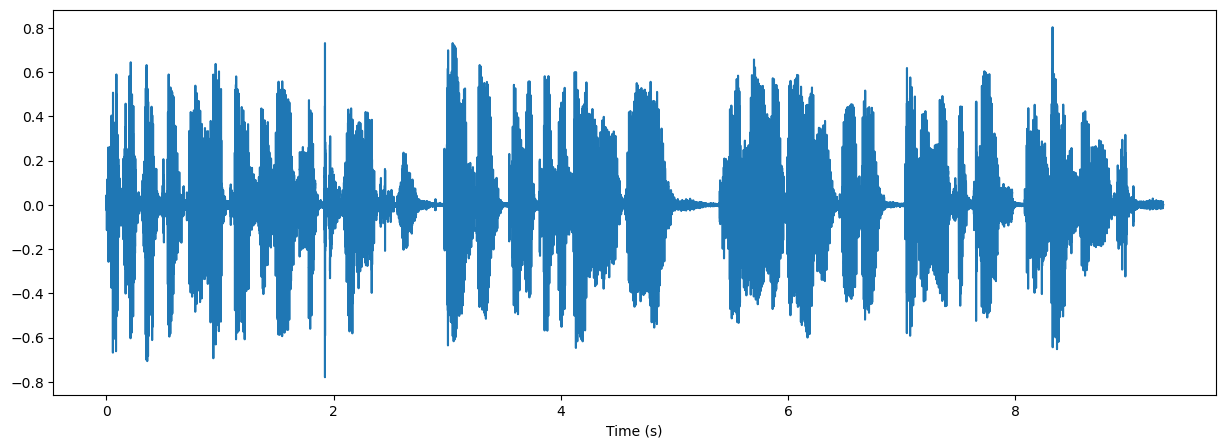

In [4]:
figure(figsize=(15, 5))
t = np.linspace(0, audio.size / 16000, audio.size)
plot(t, audio)
_ = xlabel("Time (s)")

This particular piece of audio has the following transcription.

In [5]:
import json
from pathlib import Path

trans = "Na četrtin planetu je bivav niki dilavac. Ta j biv tuliko zabavjen z dilon da ni ni glavu zdigav kad je Mići Princ prišav do njiga.".casefold()

print(trans)

na četrtin planetu je bivav niki dilavac. ta j biv tuliko zabavjen z dilon da ni ni glavu zdigav kad je mići princ prišav do njiga.


We can use the loaded processor to analyze the transcription and convert it to a list of labels.

In [6]:
labels = [
    processor.tokenizer.encoder.get(i, processor.tokenizer.unk_token_id)
    for i in trans.casefold()
]

The output of this procedure is a sequence of integers.

In [7]:
print(labels)

[16, 3, 0, 32, 7, 22, 20, 22, 11, 16, 0, 18, 14, 3, 16, 7, 22, 23, 0, 12, 7, 0, 4, 11, 24, 3, 24, 0, 16, 11, 13, 11, 0, 6, 11, 14, 3, 24, 3, 5, 47, 0, 22, 3, 0, 12, 0, 4, 11, 24, 0, 22, 23, 14, 11, 13, 17, 0, 28, 3, 4, 3, 24, 12, 7, 16, 0, 28, 0, 6, 11, 14, 17, 16, 0, 6, 3, 0, 16, 11, 0, 16, 11, 0, 9, 14, 3, 24, 23, 0, 28, 6, 11, 9, 3, 24, 0, 13, 3, 6, 0, 12, 7, 0, 15, 11, 31, 11, 0, 18, 20, 11, 16, 5, 0, 18, 20, 11, 34, 3, 24, 0, 6, 17, 0, 16, 12, 11, 9, 3, 47]


To decode their meaning, we need to use the tokenizer vocabulary.

In [8]:
vocab = processor.tokenizer.get_vocab()
rvocab = {v: k for k, v in vocab.items()}

Once decoded, we can observe that the individual tokens are simply letters of the words above. Words are delimited by a special token '|'.

In [9]:
print([rvocab[l] for l in labels])

['n', 'a', ' ', 'č', 'e', 't', 'r', 't', 'i', 'n', ' ', 'p', 'l', 'a', 'n', 'e', 't', 'u', ' ', 'j', 'e', ' ', 'b', 'i', 'v', 'a', 'v', ' ', 'n', 'i', 'k', 'i', ' ', 'd', 'i', 'l', 'a', 'v', 'a', 'c', '.', ' ', 't', 'a', ' ', 'j', ' ', 'b', 'i', 'v', ' ', 't', 'u', 'l', 'i', 'k', 'o', ' ', 'z', 'a', 'b', 'a', 'v', 'j', 'e', 'n', ' ', 'z', ' ', 'd', 'i', 'l', 'o', 'n', ' ', 'd', 'a', ' ', 'n', 'i', ' ', 'n', 'i', ' ', 'g', 'l', 'a', 'v', 'u', ' ', 'z', 'd', 'i', 'g', 'a', 'v', ' ', 'k', 'a', 'd', ' ', 'j', 'e', ' ', 'm', 'i', 'ć', 'i', ' ', 'p', 'r', 'i', 'n', 'c', ' ', 'p', 'r', 'i', 'š', 'a', 'v', ' ', 'd', 'o', ' ', 'n', 'j', 'i', 'g', 'a', '.']


Apart from processing the text, we also need to process the audio. In case of wav2vec2 models, the feature extractor simply copies the audio and adds an attention mask which is just a bunch of 1s, the same length as the audio.

In [10]:
processed = processor.feature_extractor(audio, sampling_rate=16000, return_tensors="pt")
processed

{'input_values': tensor([[ 0.1847,  0.3112,  0.2594,  ...,  0.0012, -0.0012,  0.0007]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)}

Now we can use the model to compute to log-likelihoods of the individual tokens (from the vocabulary) in time. This is done on the GPU and later copied back to CPU and converted to a numpy array.

In [11]:
import torch

with torch.no_grad():
    logits = (
        model(
            input_values=processed["input_values"].cuda(),
            attention_mask=processed["attention_mask"].cuda(),
        )
        .logits.cpu()
        .numpy()
        .squeeze()
    )

Unlike the audio (which is ~9 seconds long), the log-likelihood matrix is based on a windowed representation of the audio. Each column of the matrix represents a roughly 20 ms frame of audio. The dimension of size 40 represents the individual tokens in the vocabulary.

In [12]:
logits.shape

(464, 50)

We can draw the map on screen and observe that it recognizes the individual spoken letters just fine. Note that it also recognizes the locations of the word delimiter at word boundaries. Also note the activation of the pad token being present almost everywhere. The pad token can be chosen in almost every moment to sort of "bridge-the-gap" between consecutive tokens.

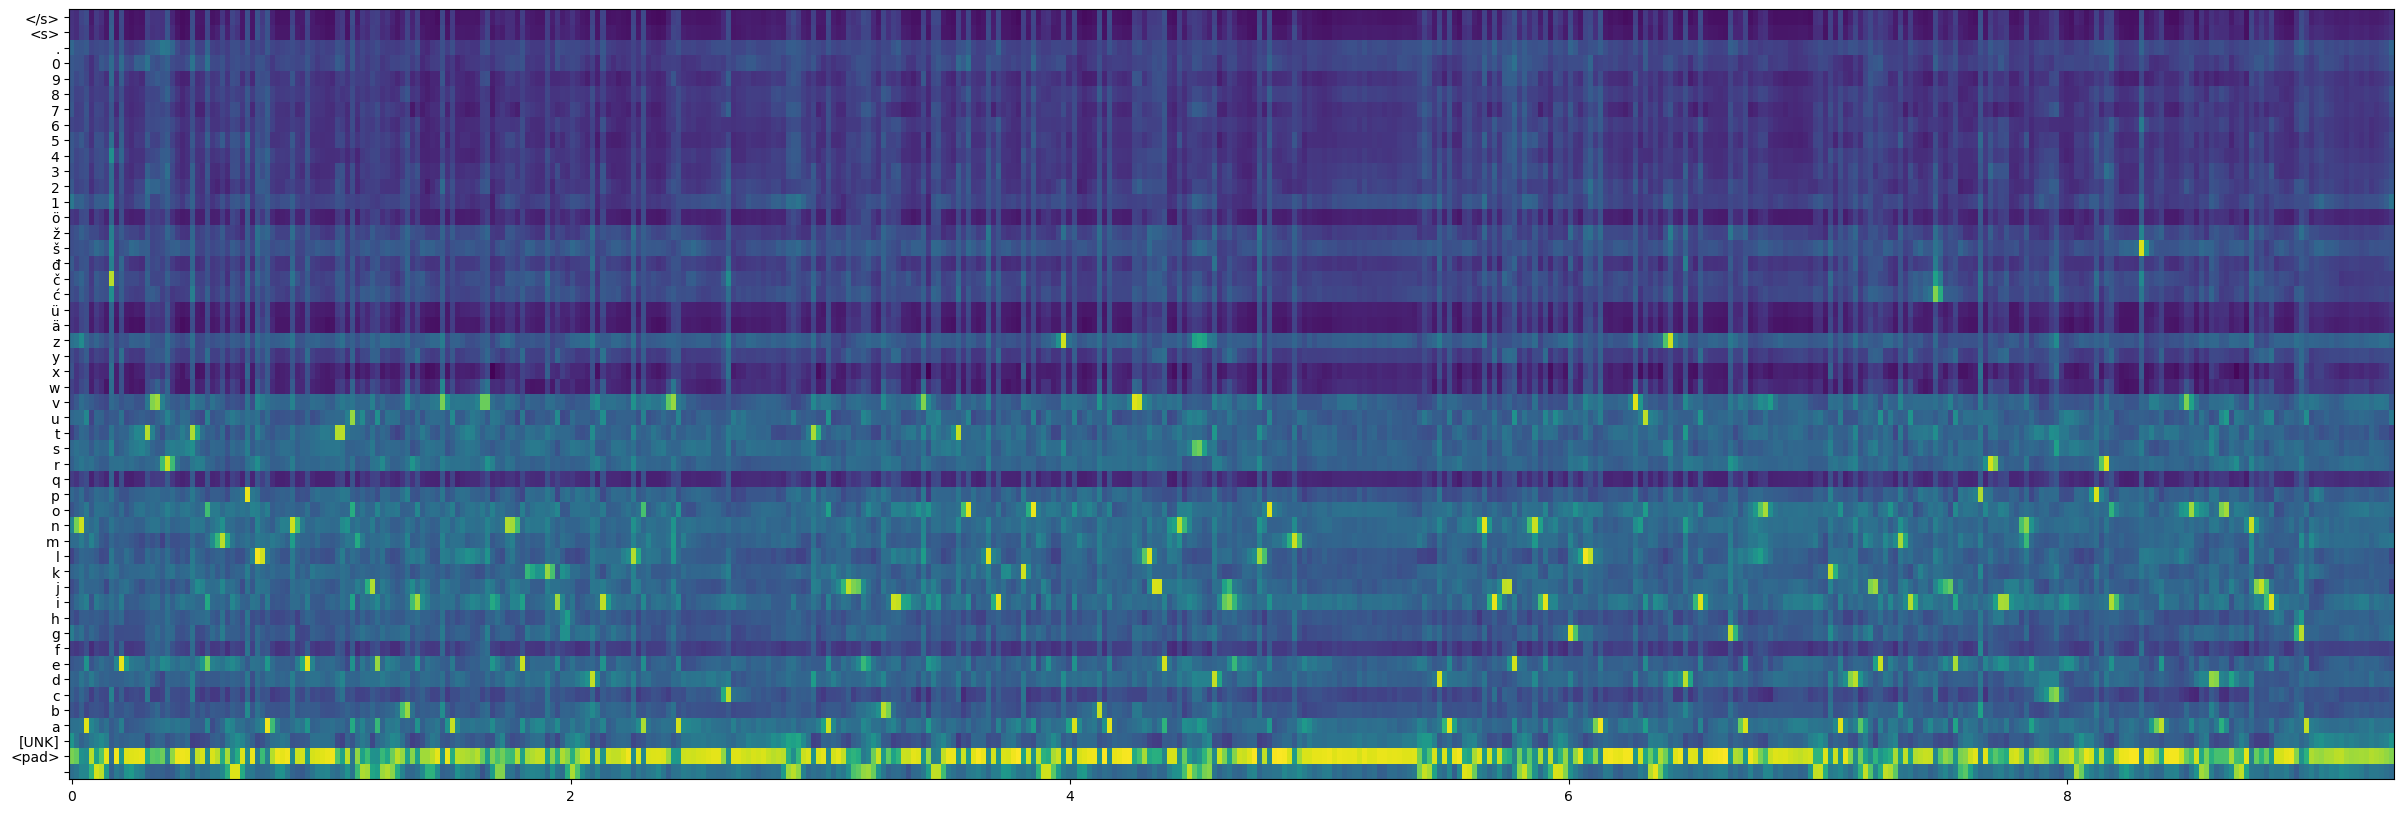

In [13]:
figure(figsize=(30, 10))

t = np.linspace(0, audio.size / 16000, logits.shape[0])
l = np.arange(logits.shape[1])

pcolormesh(t, l, logits.T)
_ = yticks(np.array(list(vocab.values())), list(vocab.keys()))

Our goal is to find a path along this sequence of tokens that decodes the text above, but also that the path has a maximum sum of likelihood values that it traversed along the way. It should be apparent that there is a large amount of different paths available. In fact, the way to solve this is to construct a datastructure known as the trellis, which is a graph that represents all the possible paths and then simply create an algorithm which finds the one with the best likelihood.

The Viterbi algorithm implemented below is based on the paper: Rabiner, Lawrence R. "A tutorial on hidden Markov models and selected applications in speech recognition." Proc. IEEE 77 (1989): 257-286.

In [14]:
def viterbi(
    logits: np.ndarray,
    labels: np.ndarray,
    pad_id: int = processor.tokenizer.pad_token_id,
) -> Tuple[List[int], np.ndarray]:
    T = logits.shape[0]
    N = len(labels)
    delta = np.zeros((T, N))
    psi = np.zeros((T, N), dtype=int)

    delta[0, :] = -np.inf
    delta[0, 0] = logits[0][pad_id]

    a = np.zeros((N,))
    b = np.zeros((N,))
    o = np.zeros((N,))
    M = np.arange(N)

    for t in range(1, T):
        delta[t, :] = -np.inf
        beg = np.clip(t - T + N, 0, N - 1)
        end = np.clip(t + 1, 0, N)

        r = np.arange(beg, end)
        ra = np.clip(r, 1, N - 1)

        a[ra] = delta[t - 1][ra - 1]
        b[r] = delta[t - 1][r]

        o[r] = logits[t][labels[r]]
        opad = logits[t][pad_id]

        m = np.zeros(N, dtype=bool)
        m[ra] = (a > b)[ra]
        delta[t][m] = a[m] + o[m]
        psi[t][m] = M[m] - 1

        m = np.zeros(N, dtype=bool)
        m[r] = (a <= b)[r]
        delta[t][m] = b[m] + opad
        psi[t][m] = M[m]

    bestpath = [delta[T - 1].argmax()]
    for t in range(T - 2, -1, -1):
        bestpath.append(psi[t + 1][bestpath[-1]])
    bestpath.reverse()
    return bestpath, delta

To run the algorithm, we use the above label sequence but add a word delimiter token at the start and the end.

In [15]:
lf = (
    (processor.tokenizer.pad_token_id,)
    + tuple(labels)
    + (processor.tokenizer.pad_token_id,)
)
bestpath, delta = viterbi(logits, np.array(lf))

We can draw the forward probabilities of the trellis as color values and use the solid line to represent the best path. The gray areas the locations that cannot be accessed.

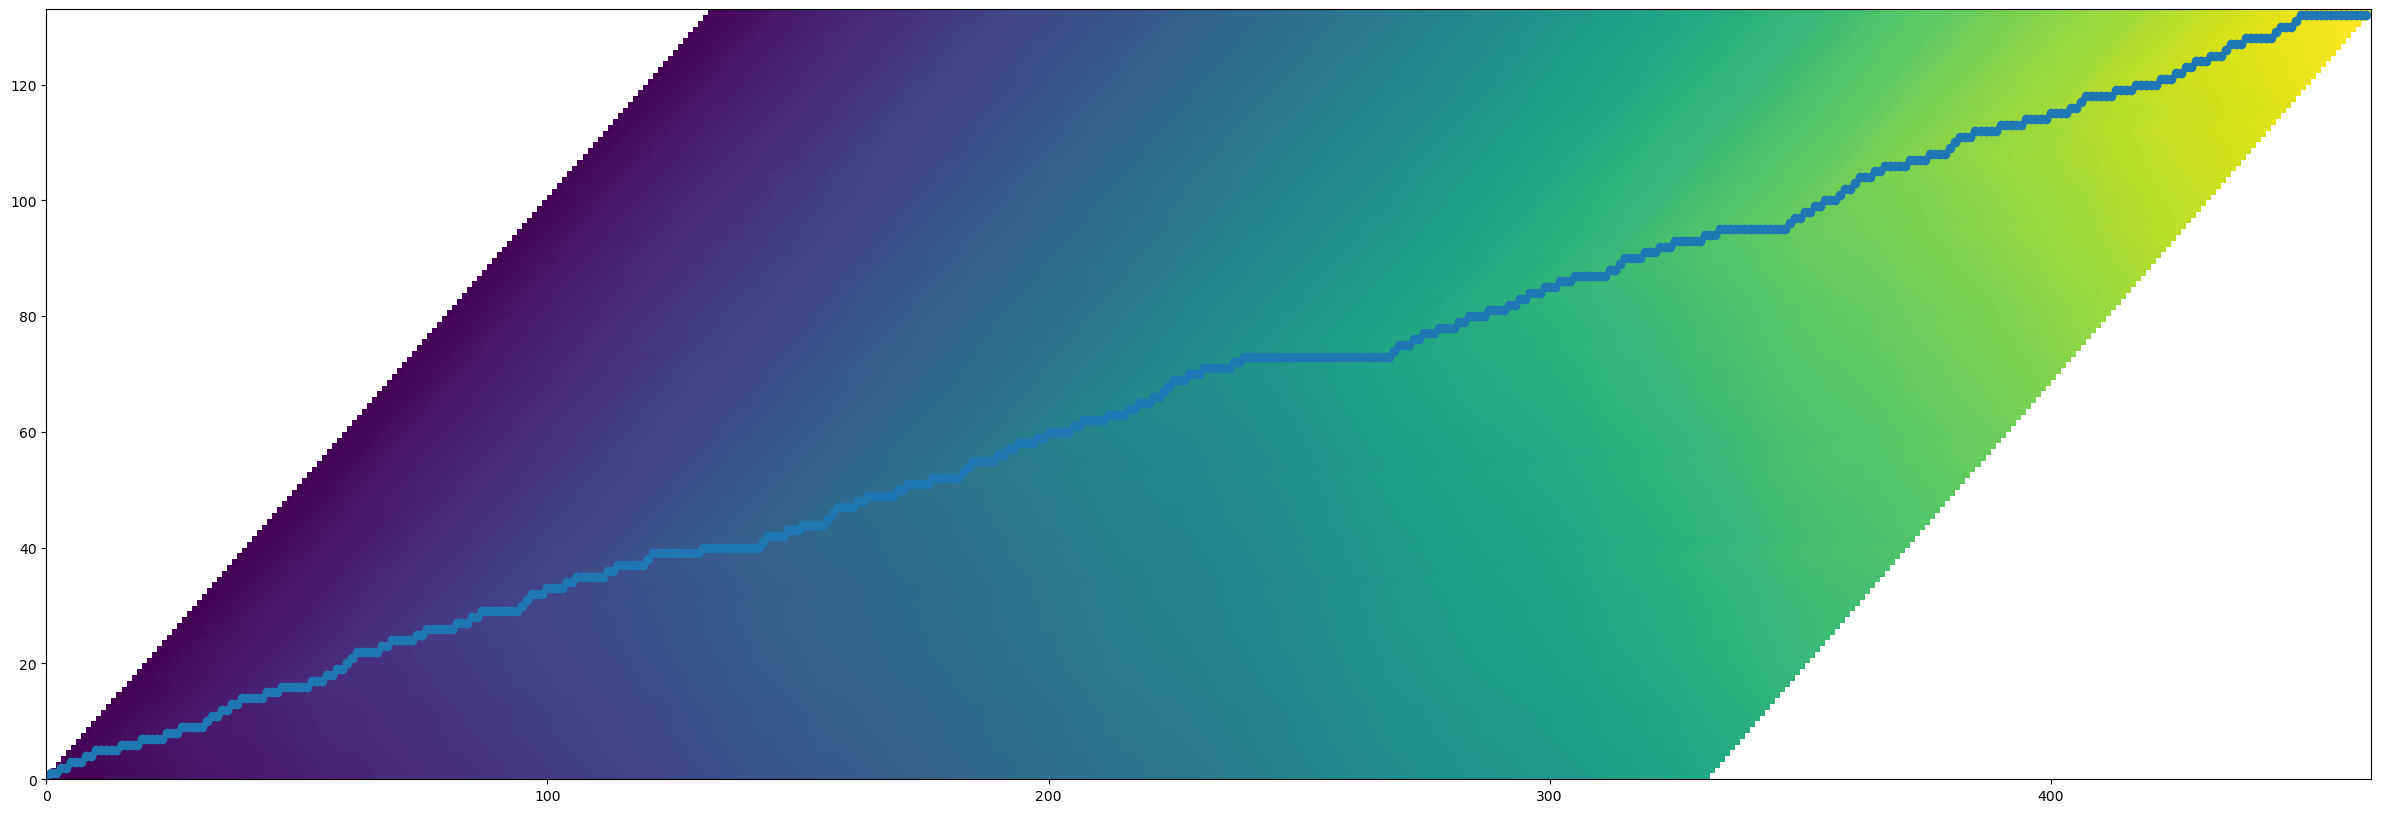

In [16]:
figure(figsize=(30, 10))
pcolormesh(delta.T)
scatter(list(range(logits.shape[0])), bestpath)

To get the word timings, we need to detect the individual word boundary tokens.

In [17]:
def align(
    logits: np.ndarray,
    labels: List[int],
    fr_len: float = 0.02,
    wl_id: int = processor.tokenizer.encoder[" "],
) -> np.ndarray:
    labels = (wl_id,) + tuple(labels) + (wl_id,)
    bestpath, _ = viterbi(logits, np.array(labels))

    dur = []
    ls = 0
    for t, p in enumerate(bestpath):
        if labels[p] == wl_id:
            if t > ls:
                dur.append((ls, t))
            ls = t + 1

    return np.array(dur) * fr_len

These are the timings acquired by the above procedure.

In [18]:
word_lens = align(logits, labels)
word_lens

array([[0.02, 0.1 ],
       [0.16, 0.66],
       [0.7 , 1.16],
       [1.2 , 1.24],
       [1.34, 1.7 ],
       [1.74, 2.  ],
       [2.08, 2.88],
       [2.96, 3.12],
       [3.14, 3.16],
       [3.24, 3.44],
       [3.54, 3.88],
       [3.96, 4.46],
       [4.48, 4.5 ],
       [4.56, 5.4 ],
       [5.46, 5.56],
       [5.64, 5.76],
       [5.84, 5.92],
       [5.98, 6.3 ],
       [6.38, 6.98],
       [7.02, 7.16],
       [7.18, 7.24],
       [7.3 , 7.6 ],
       [7.62, 8.  ],
       [8.08, 8.5 ],
       [8.54, 8.64],
       [8.7 , 9.26]])

If we superimpose them on the audio, we can verify that they look mostly okay.

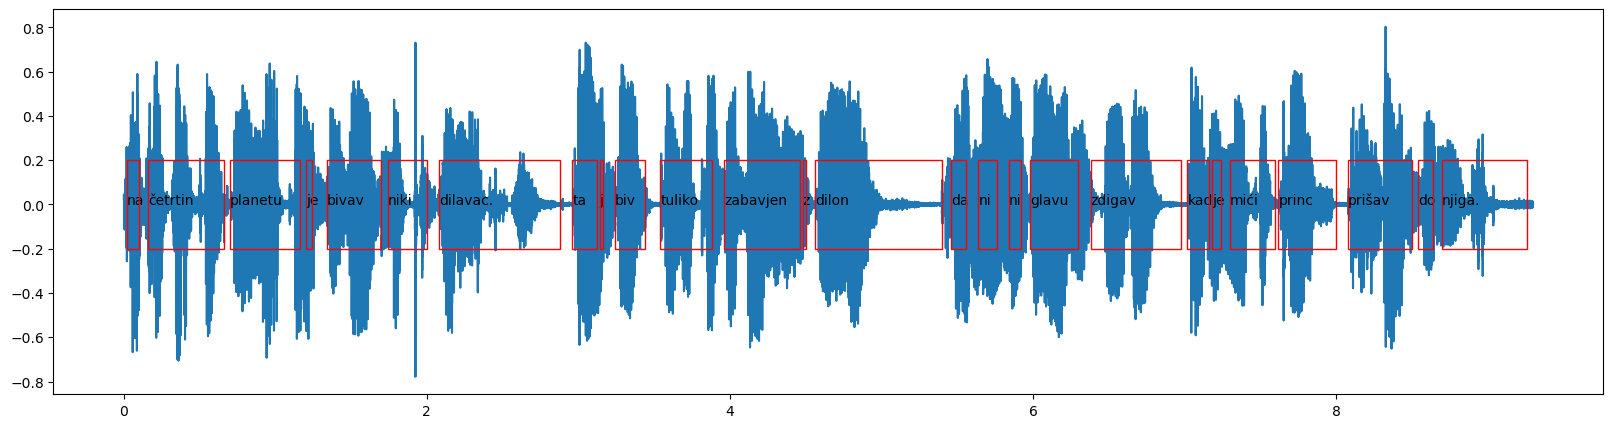

In [19]:
t = np.linspace(0, audio.size / 16000, audio.size)

fig, ax = subplots(figsize=(20, 5))
ax.plot(t, audio)
for w, (b, e) in zip(trans.split(), word_lens):
    ax.annotate(w, (b, 0))
    ax.add_patch(
        Rectangle(
            (b, 0.2), e - b, -0.4, fill=None, linestyle="-", edgecolor="r", zorder=100
        )
    )

But to make extra sure, we can extract the audio segment for each individual word and play it back.

In [20]:
Fs = 16000
for i, (w, (b, e)) in enumerate(zip(trans.split(), word_lens)):
    if i == 5:
        break
    seg = audio[int(b * Fs) : int(e * Fs)]
    display(w)
    display(IPyAudio(seg, rate=Fs))

'na'

'četrtin'

'planetu'

'je'

'bivav'

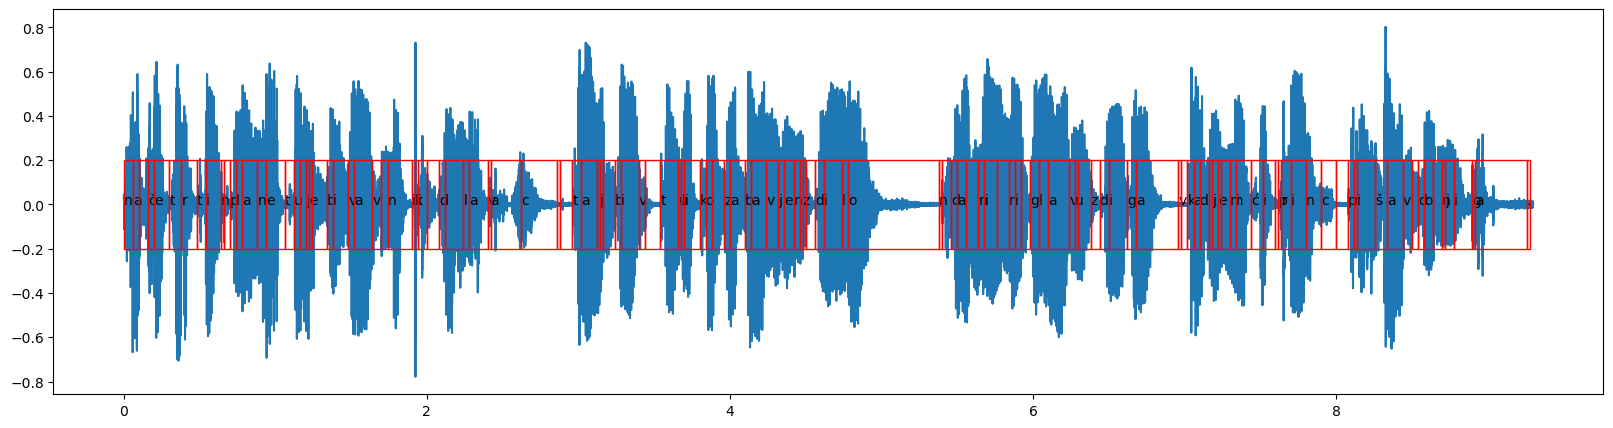

In [21]:
def align(logits: np.ndarray, labels: List[int], fr_len: float = 0.02) -> np.ndarray:
    # Use character labels directly (no word-level ID handling)
    bestpath, _ = viterbi(logits, np.array(labels))

    # Calculate the duration for each aligned character
    char_durations = []
    current_char = bestpath[0]  # Start with the first character
    start_frame = 0

    for t, p in enumerate(bestpath):
        if p != current_char:  # If we encounter a new character
            char_durations.append(
                (start_frame, t)
            )  # Append start and end frame for the last character
            current_char = p  # Update to the new character
            start_frame = t  # Reset the start frame

    # Append the duration for the final character
    char_durations.append((start_frame, len(bestpath)))

    # Each duration corresponds to a character in 'trans' and should have the same length
    assert len(char_durations) == len(
        labels
    ), f"Mismatch: {len(char_durations)} durations, {len(labels)} labels."

    # Convert frame durations into time durations using fr_len (frame length)
    return np.array([[start, end] for start, end in char_durations]) * fr_len


# Align characters and get the result
char_lens = align(logits, labels)
char_lens


t = np.linspace(0, audio.size / 16000, audio.size)

fig, ax = subplots(figsize=(20, 5))
ax.plot(t, audio)
for w, (b, e) in zip(trans, char_lens):
    ax.annotate(w, (b, 0))
    ax.add_patch(
        Rectangle(
            (b, 0.2), e - b, -0.4, fill=None, linestyle="-", edgecolor="r", zorder=100
        )
    )


# Fs = 16000
# for i, (w, (b, e)) in enumerate(zip(trans, char_lens)):
#     if i >= 5:
#         break
#     seg = audio[int(b * Fs) : int(e * Fs)]
#     display(w)
#     display(IPyAudio(seg, rate=Fs))

In [22]:
char_lens

array([[0.  , 0.06],
       [0.06, 0.1 ],
       [0.1 , 0.16],
       [0.16, 0.2 ],
       [0.2 , 0.3 ],
       [0.3 , 0.38],
       [0.38, 0.48],
       [0.48, 0.54],
       [0.54, 0.64],
       [0.64, 0.66],
       [0.66, 0.7 ],
       [0.7 , 0.74],
       [0.74, 0.78],
       [0.78, 0.88],
       [0.88, 0.94],
       [0.94, 1.06],
       [1.06, 1.12],
       [1.12, 1.16],
       [1.16, 1.2 ],
       [1.2 , 1.22],
       [1.22, 1.24],
       [1.24, 1.34],
       [1.34, 1.38],
       [1.38, 1.48],
       [1.48, 1.52],
       [1.52, 1.64],
       [1.64, 1.7 ],
       [1.7 , 1.74],
       [1.74, 1.9 ],
       [1.9 , 1.92],
       [1.92, 1.94],
       [1.94, 2.  ],
       [2.  , 2.08],
       [2.08, 2.12],
       [2.12, 2.24],
       [2.24, 2.28],
       [2.28, 2.4 ],
       [2.4 , 2.42],
       [2.42, 2.62],
       [2.62, 2.86],
       [2.86, 2.88],
       [2.88, 2.96],
       [2.96, 3.02],
       [3.02, 3.12],
       [3.12, 3.14],
       [3.14, 3.16],
       [3.16, 3.24],
       [3.24,